In [5]:
%matplotlib inline

**Problém 1**: Rovnice advekce-difůze 

$$
\frac{\partial u}{\partial t} + v \frac{\partial u}{\partial x} = D\frac{\partial^2 u}{\partial t^2}
$$


najděte numerické řešení v intervalu $x = [1, 2]$ a s počatečními podmínkami $u = 1$ pro $x \leq 1.5$ a $u = 0$ pro $x > 1.5$. Vyzkoušejte různé hodnoty konstantni rychlosti advekce $v$ a koeficientu difůze.

Nejprve naimportujeme potřebné knihovny pro práci s poli a kreslení

In [20]:
from __future__ import division

import numpy as np
from matplotlib import pyplot as plt

Dále je potřeba určit počáteční podmínky našeho problému, správněji řečeno profil funkce $u(x,t=0)$. Pro naše účely si vystačíme s jednoduchým profilem ve tvaru obdelníkového pulsu a schodu.

In [21]:
def box_profile(x):
    
    u = np.ones_like(x)
    ubound = np.where(x >= 0.5)
    lbound = np.where(x <= 1)
    u[np.intersect1d(lbound,ubound)] = 2.0
    
    return u

def step_profile(x):
    u = np.ones_like(x); u[x > 1.5] = 0
    return u


Abychom se ujistili, že jsou naše počáteční podmínky správně, zobrazíme si tvar obou dvou profilů s využitím knihovny matplotlib

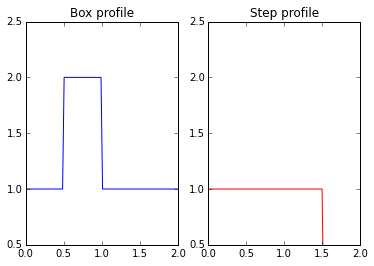

In [22]:
x = np.linspace(0, 2, 100)
u1 = box_profile(x)
u2 = step_profile(x)

plt.figure(1)

plt.subplot(121)
plt.title('Box profile')
plt.ylim((0.5,2.5))
plt.xlim((0,2))
plt.plot(x, u1, 'b-')

plt.subplot(122)
plt.title('Step profile')
plt.ylim(0.5,2.5)
plt.xlim((0,2))
plt.plot(x,u2,'r-')

Pro zobrazení finálního výsledku si připravíme funkci, která vykreslí numerické řešení...

In [23]:
def plot_result(x,u,title=' ',xmin=0.0,xmax=2.0,ymin=0.5,ymax=2.5):
    ## Plotting of the result      
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("u")
    plt.ylim((ymin,ymax))
    plt.xlim((xmin,xmax))
    plt.plot(x, u)
    plt.grid(True)

### Lax-Wendorfova metoda ###
Jako první metodu pro řešení rovnice advekce-difůze, použijeme Laxovu metodu, viz kapitola () skript. Funkce bude mít jako vstupní parametry čas a rychlost advekce. Hodnotu parametrů rychlosti advekce $v$ zvolíme pro jednoduchost nulovou, bude se tedy jednat o difůzní problém, tomu také odpovídá velikost zvoleného časového kroku (viz. skriptum).

In [39]:
def lax_method(time = 0.1, velocity=0.0):
    
    number_of_points = 100
    
    D = 0.3
    v = velocity
    t_end = time
    
    dx = 2./(number_of_points-1)
    dt = 0.2*dx**2.0/D
        
    x = np.linspace(0, 2, number_of_points)
    
    u = box_profile(x)
    
    cas = 0.0
    
    while cas < t_end:
        
        for i in range(1, len(u)-1):
            u[i] = 0.5*(u[i+1]+u[i-1]) - 0.5*v*dt/dx*(u[i] - u[i-1]) +\
            D*dt/(dx**2.0)*(u[i+1]-2*u[i]+u[i-1])
        cas = cas + dt
        
    return x,u


Nyní nám již nic nebrání v otestování našeho numerického řešení. Spustíme funkci a vykreslíme vysledný průběh. Použijeme přitom také magický příkaz **%time**, který nám vypíše dobu výpočtu - položka *Wall time*. 

CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 51.4 ms


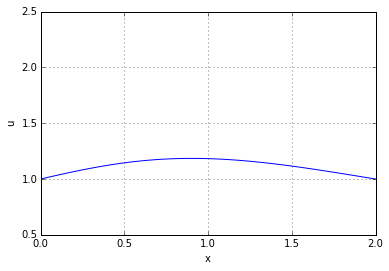

In [40]:
%time x,u = lax_method()
plot_result(x,u)


Jak je vidno, metoda pracuje relativně dobře, nicméně není příliš efektivni, dobu výpočtu můžeme výrazně zkrátit. Nejnáročnější část výpočtu se schovává v cyklu

        for i in range(1, len(u)-1):
            u[i] = 0.5*(uu[i+1]+u[i-1]) - 0.5*v*dt/dx*(uu[i] - uu[i-1]) +\
            D*dt/(dx**2.0)*(uu[i+1]-2*uu[i]+uu[i-1])

Tuto část však lze výrazně urychlit využitím *slice* indexování (více viz. [Slicing](http://docs.scipy.org/doc/numpy-1.10.0/reference/arrays.indexing.html)). Výhodou je, že v této formě lze použít vektorový přístup při výpočtu, což významně zefektivní výpočet. Přepíšeme tedy předchozí metodu do této vektorové formy s pomocí již zmíněného *slice* indexování

In [49]:
def lax_method(time = 0.1, velocity=0.0):
    
    number_of_points = 100
    
    D = 0.3
    v = velocity
    t_end = time
    
    dx = 2./(number_of_points-1)
    dt = 0.2*dx**2.0/D
        
    x = np.linspace(0, 2, number_of_points)
    
    u = box_profile(x)
    
    cas = 0.0
    
    while cas < t_end:
#        uu = np.copy(u)
        
        u[1:-1] = 0.5*(u[2:]+u[0:-2])-0.5*v*dt/dx*(u[1:-1]-u[:-2])+\
        D*dt/(dx**2.0)*(u[2:]-2.0*u[1:-1]+u[0:-2])
        
        cas = cas + dt
        
    return x,u

A porovnáme dobu výpočtu

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 2.72 ms


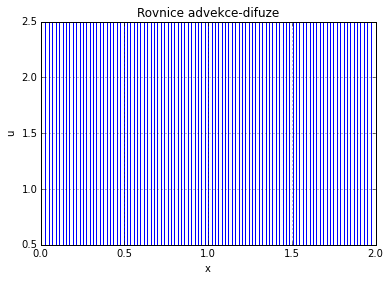

In [50]:
%time x,u = lax_method()
plot_result(x,u,title='Rovnice advekce-difuze')

Vidíme, že doba výpočtu senám zkrátila a to zhruba 17-násobně.

IPython však umí mnohem více, určitě by bylo vhodné mít možnost měnit hodnoty řídích parametrů problému a neomezovat se tak pouze na pevně zvolené. Lze tím ilustrovat vliv řídících parametru na řešení problému. Typicky zvětšováním hodnoty difůze se stane proces difůze dominantním, analogicky pak zvětšování hodnoty rychlosti zase proces advekce. To má ovšem značný vliv na stabilitu numerického řešení, jak si ukážeme v další části.

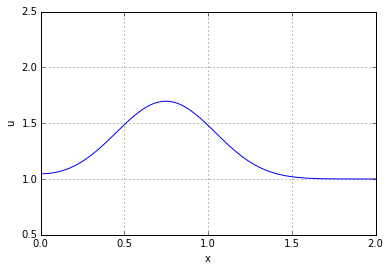

In [20]:
from ipywidgets import interact

@interact(t_end=(0, 1.0), velocity=(0.0, 1.0), D = (0.01,0.5))
def lax_method(t_end=0.1,velocity=0.0,D=0.3):
    D = D
    v = velocity
    t_end = t_end
    
    number_of_points = 104
    dx = 2./(number_of_points-1)
    
    x = np.linspace(0, 2, number_of_points)
    dt = 0.2*dx**2.0/D
    
    u = box_profile(x)
    
    time = 0.0
    
    while time < t_end:
        uu = np.copy(u)

        u[1:number_of_points-2] =uu[1:number_of_points-2]-\
        v*dt/dx*(uu[1:number_of_points-2]-uu[:number_of_points-3])+D*dt/(dx*dx)*\
        (uu[2:number_of_points-1]-2*uu[1:number_of_points-2]+uu[:number_of_points-3])

        u[0] = u[1]
        u[number_of_points-1] = u[number_of_points-2]

        time = time + dt
    plot_result(x,u)
    return

### Crank-Nicholsonova metoda ###
Předchozí metoda řešení rovnice advekce-difůze použila explicitní schéma, můžeme však použít (a mnohdy je to i velmi vhodne) implicitní schéma. Nejznámějším příkladem takého schématu je *Crankovo-Nicholsonovo* schéma

In [21]:
import scipy.linalg as sp


In [22]:
#@interact(t_end=(0.0,0.2),velocity=(0.01,1.2),D=(0.0,0.3))
def crank_nicholson(t_end,velocity,D):
    
    #Inicializace poli
    number_of_points = 100
    u = np.empty(number_of_points+2)
    x = np.linspace(1,2,number_of_points+2)
    u = np.ones_like(x); u[x > 1.5] = 0

    # Prostorovy a casovy krok
    dx = x[1]-x[0]
    D = D
    
    # Parametry problemu 
    # v ... rychlost je kladna, zaporne znamenko vznika prechodem na druhou stranu
    
    v = -velocity
    dt = 0.005
    t_end = t_end

    main = np.empty(number_of_points)
    lower = np.empty(number_of_points -1)
    upper = np.empty(number_of_points -1)
 
    right_side = np.empty(number_of_points)

    matrix = np.zeros((number_of_points, number_of_points))

    # Koefecienty pro jednotlive cleny pravych stran
    sigma = D*dt/(2.0*dx*dx)
    rho = v*dt/(4.0*dx)

    main[:] = (1.0+2.0*sigma)
    upper[:] = -(sigma+rho)
    lower[:] = (-sigma+rho)

    # Boundary condition
    main[0] = (1.0+sigma+rho)
    main[number_of_points-1] = (1.0+sigma-rho)

    for i in range(number_of_points):
        matrix[i,i] = main[i]
    
    for i in range(number_of_points-1):
        matrix[i+1,i] = lower[i]
        matrix[i,i+1] = upper[i]

    cas = 0.0

    # Hlavni cyklus
    while cas < t_end:
        right_side[1:number_of_points] = u[1:number_of_points]*(1.0-2.0*sigma)+u[2:number_of_points+1]*(sigma+rho)+\
        u[0:number_of_points-1]*(sigma-rho)


        # boundary condition 
        right_side[0] = u[0]*(1.0-sigma-rho)+(sigma+rho)*u[1]
        right_side[number_of_points-1] = u[number_of_points-2]*(sigma-rho)+(1.0-sigma+rho)*u[number_of_points-1]
    
        solution = sp.solve(matrix,right_side)
        u[1:number_of_points+1]=solution
        cas = cas + dt
        
    #plot_result(x,u,title='Crank-Nicholson',xmin=1.0,xmax=2.0,ymin=0,ymax=1.2)
    return x,u

In [23]:
%time x,u = crank_nicholson(t_end=0.1, velocity=0.0, D = 0.3)

CPU times: user 12 ms, sys: 20 ms, total: 32 ms
Wall time: 11.9 ms
